In [6]:
import rdkit
from rdkit import Chem
import pandas as pd
import json
import ast
import matplotlib.pyplot as plt

Data loading

In [4]:
df = pd.read_csv('MatDX_EF.csv')

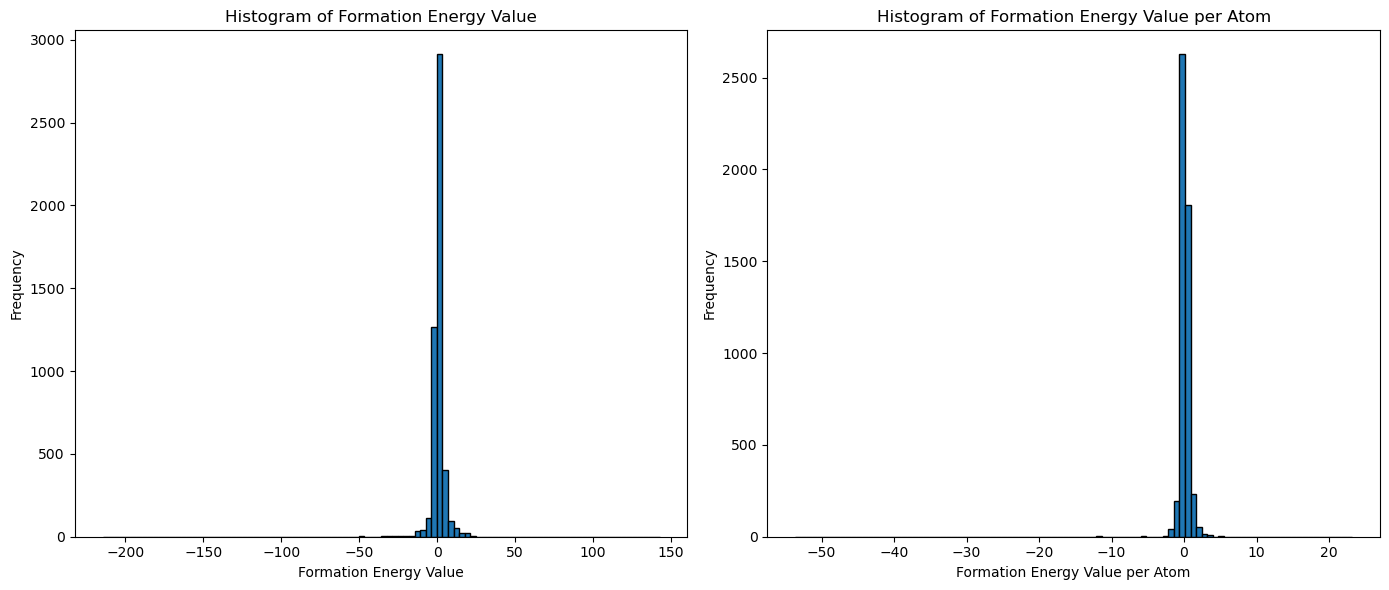

In [7]:
# Assuming df is already loaded and contains 'formation_energy' column with dictionary-like string data

# Convert 'formation_energy' column from string to dictionary if needed
df['formation_energy'] = df['formation_energy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract 'value' and 'value_per_atom' from 'formation_energy' column
df['formation_energy_value'] = df['formation_energy'].apply(lambda x: x.get('value') if isinstance(x, dict) else None)
df['formation_energy_value_per_atom'] = df['formation_energy'].apply(lambda x: x.get('value_per_atom') if isinstance(x, dict) else None)

# Drop any NaN values in the 'formation_energy_value' and 'formation_energy_value_per_atom' columns
values = df['formation_energy_value'].dropna()
values_per_atom = df['formation_energy_value_per_atom'].dropna()

# Plot histograms for 'value' and 'value_per_atom'
plt.figure(figsize=(14, 6))

# Histogram for 'formation_energy_value'
plt.subplot(1, 2, 1)
plt.hist(values, bins=100, edgecolor='black')
plt.xlabel('Formation Energy Value')
plt.ylabel('Frequency')
plt.title('Histogram of Formation Energy Value')

# Histogram for 'formation_energy_value_per_atom'
plt.subplot(1, 2, 2)
plt.hist(values_per_atom, bins=100, edgecolor='black')
plt.xlabel('Formation Energy Value per Atom')
plt.ylabel('Frequency')
plt.title('Histogram of Formation Energy Value per Atom')

plt.tight_layout()
plt.show()

Filtering to remove datapoints having more than +-5 eV for formation energy per atom

In [20]:
df['formation_energy'] = df['formation_energy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract 'value' and 'value_per_atom' from 'formation_energy' column
df['formation_energy_value'] = df['formation_energy'].apply(lambda x: x.get('value') if isinstance(x, dict) else None)
df['formation_energy_value_per_atom'] = df['formation_energy'].apply(lambda x: x.get('value_per_atom') if isinstance(x, dict) else None)

# Remove rows where 'formation_energy_value_per_atom' is outside the range of -5 to 5
df_cleaned = df[(df['formation_energy_value_per_atom'] <= 5) & (df['formation_energy_value_per_atom'] >= -5)].reset_index(drop=True)


# Save the cleaned DataFrame to an Excel file
df_cleaned.to_csv('MatDX_EF_cleaned.csv', index=False)

# Display the cleaned DataFrame
df_cleaned

,original_index,formula,space_group,structure,id,formation_energy,formation_energy_value,formation_energy_value_per_atom
0,0,Ni4Ta6,R-3c,"[{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3...",PN_MCKVEQNTJFRUHOURCR2HCEB35KDFRETL,{'reference': {'Ni': 'https://nomad-lab.eu/pro...,1.017402,0.101740
1,1,Mn4Sb2,I4_1/amd,"[{'data': {'a': [-1.87778212e-10, 1.87604249e-...",PN_FGGHB2NFWUCYD3YZO4FWN3QVOKCTVI6K,{'reference': {'Mn': 'https://nomad-lab.eu/pro...,2.975885,0.495981
2,2,Ir2Na2,Imma,"[{'data': {'a': [-1.36776653e-10, 2.60817299e-...",PN_BAO7ZSBZZCMA7PH7QMR7WLDI72GOELND,{'reference': {'Na': 'https://nomad-lab.eu/pro...,1.888520,0.472130
3,3,MoSm,R-3m,"[{'data': {'a': [1.65820251e-10, 9.57363439999...",PN_4YR2JLVZHJLC3F2TYPTOVDBJJ52C6XIE,{'reference': {'Mo': 'https://nomad-lab.eu/pro...,1.022825,0.511413
4,4,Sn17P12,I-43m,"[{'data': {'a': [-5.563178910000001e-10, 5.563...",PN_H6P36AVAKDU244QNQGGCJ7YLC4A4F2YE,{'reference': {'P': 'https://nomad-lab.eu/prod...,6.236779,0.215061
...,...,...,...,...,...,...,...,...
4977,4977,Ag3Br,P4/mmm,"[{'data': {'a': [3.54083755e-10, 0, 0], 'b': [...",PN_GGP4J67ICWQHYNTSDBZQJFBJKFHKP2TY,{'reference': {'Br': 'https://nomad-lab.eu/pro...,-0.186508,-0.046627
4978,4978,Al16Ge8,Fd-3m,"[{'data': {'a': [0, 6.01749067e-10, 6.01749067...",PN_HZ6TO4YLVA2K7PWWHZJRSFEAYOZLE3WF,{'reference': {'Al': 'https://nomad-lab.eu/pro...,4.803874,0.200161
4979,4979,Pt2Th2,Cmcm,"[{'data': {'a': [-3.93770842e-10, 0, 0], 'b': ...",PN_5CPW22CGT4NOR6246BCGTZUO2UMDXXWI,{'reference': {'Th': 'https://nomad-lab.eu/pro...,-4.940262,-1.235066
4980,4980,Ga5Sr,Cmmm,"[{'data': {'a': [2.2508728800000003e-10, -6.32...",PN_Y33JSPVMM6O4AYYYNR2LHUUT5WFVXJJC,{'reference': {'Ga': 'https://nomad-lab.eu/pro...,-1.094989,-0.182498


Check unique

In [12]:
unique_elements = set()
for formula in df_cleaned['formula']:
    # Extract elements based on uppercase letters followed by lowercase letters or numbers
    elements = [part for part in formula if part.isalpha()]
    unique_elements.update(elements)

# Count unique elements and unique space groups
num_unique_elements = len(unique_elements)
num_unique_space_groups = df_cleaned['space_group'].nunique()

num_unique_formula = df_cleaned['formula'].nunique()

num_unique_elements, num_unique_space_groups, num_unique_formula

(35, 78, 3277)

In [13]:
# Sample code to identify how many examples in 'df' have the same 'formula' but different 'space_group'

# Group by 'formula' and check unique 'space_group' counts for each group
duplicates_with_different_space_group = df_cleaned.groupby('formula')['space_group'].nunique()

# Filter to find cases where there is more than one unique 'space_group' for the same 'formula'
duplicates_count = (duplicates_with_different_space_group > 1).sum()

duplicates_count


np.int64(683)

In [16]:
# Reset index to keep track of original indices
df_cleaned = df_cleaned.reset_index().rename(columns={'index': 'original_index'})

# Count occurrences of each (formula, space_group) pair to find exact duplicates
duplicate_pairs = df.groupby(['formula', 'space_group']).size()
exact_duplicates = duplicate_pairs[duplicate_pairs > 1].reset_index(name='count')

# Filter the original DataFrame to include only exact duplicate pairs and keep original indices
duplicate_df = df_cleaned.merge(exact_duplicates[['formula', 'space_group']], on=['formula', 'space_group'])

# Convert 'formation_energy' from string to dictionary if needed
duplicate_df['formation_energy'] = duplicate_df['formation_energy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract 'value' and 'value_per_atom' from the 'formation_energy' dictionary
duplicate_df['formation_energy_value'] = duplicate_df['formation_energy'].apply(lambda x: x.get('value') if isinstance(x, dict) else None)
duplicate_df['formation_energy_value_per_atom'] = duplicate_df['formation_energy'].apply(lambda x: x.get('value_per_atom') if isinstance(x, dict) else None)

# Convert extracted columns to numeric, forcing non-numeric values to NaN
duplicate_df['formation_energy_value'] = pd.to_numeric(duplicate_df['formation_energy_value'], errors='coerce')
duplicate_df['formation_energy_value_per_atom'] = pd.to_numeric(duplicate_df['formation_energy_value_per_atom'], errors='coerce')

# Check if conversion was successful
print("Data types after conversion:")
print(duplicate_df[['formation_energy_value', 'formation_energy_value_per_atom']].dtypes)
print("\nAny NaN values in 'formation_energy_value':", duplicate_df['formation_energy_value'].isna().any())
print("Any NaN values in 'formation_energy_value_per_atom':", duplicate_df['formation_energy_value_per_atom'].isna().any())

# Now proceed with aggregation, assuming data types are now clean
stats = duplicate_df.groupby(['formula', 'space_group']).agg(
    unique_value_count=('formation_energy_value', 'nunique'),
    datapoint_count=('formation_energy_value', 'size'),
    formation_energy_mean=('formation_energy_value', 'mean'),
    formation_energy_std=('formation_energy_value', 'std'),
    formation_energy_per_atom_mean=('formation_energy_value_per_atom', 'mean'),
    formation_energy_per_atom_std=('formation_energy_value_per_atom', 'std'),
    original_indices=('original_index', list)
).reset_index()

# Display the final result
stats

Data types after conversion:
formation_energy_value             float64
formation_energy_value_per_atom    float64
dtype: object

Any NaN values in 'formation_energy_value': False
Any NaN values in 'formation_energy_value_per_atom': False


,formula,space_group,unique_value_count,datapoint_count,formation_energy_mean,formation_energy_std,formation_energy_per_atom_mean,formation_energy_per_atom_std,original_indices
0,Ac4Br6,R-3c,2,2,-14.694957,0.102140,-1.469496,0.010214,"[583, 3818]"
1,Ac4I6,R-3c,2,2,-11.355718,0.142808,-1.135572,0.014281,"[14, 1019]"
2,AcAl3,I4/mmm,2,2,-0.090564,0.008318,-0.022641,0.002079,"[1832, 1959]"
3,AcMn,P4/mmm,2,2,0.760808,0.090197,0.380404,0.045098,"[81, 253]"
4,Ag2Al,I4/mmm,2,2,-0.186167,0.000004,-0.062056,0.000001,"[570, 1000]"
...,...,...,...,...,...,...,...,...,...
645,WBr,Cmmm,2,2,2.609098,0.004551,1.304549,0.002276,"[3031, 4502]"
646,WP3,Fm-3m,2,2,1.559718,0.003170,0.389930,0.000792,"[1926, 2052]"
647,WSb,Pm-3m,4,4,1.915868,0.741730,0.638169,0.004431,"[242, 1095, 2109, 2448]"
648,YbBr,Fm-3m,2,2,-2.837811,0.023230,-1.418905,0.011615,"[3104, 3114]"


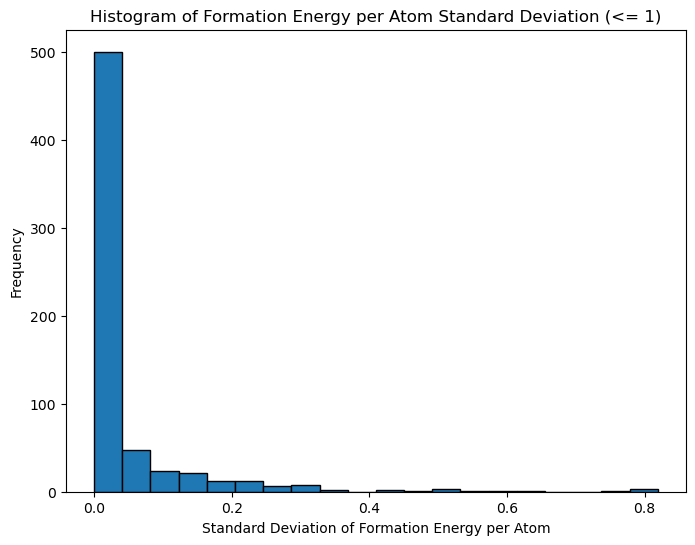

In [17]:
filtered_data = stats[stats['formation_energy_per_atom_std'] <= 1]

# Plotting the histogram of formation_energy_per_atom_std with the filtered data
plt.figure(figsize=(8, 6))
plt.hist(filtered_data['formation_energy_per_atom_std'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Standard Deviation of Formation Energy per Atom')
plt.ylabel('Frequency')
plt.title('Histogram of Formation Energy per Atom Standard Deviation (<= 1)')
plt.show()